# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту будет предлагатся внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.


На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Наметим первычный план:
1) Выгрузка и обзор данных.
2) Предобработка данных.
   * Преобразование форматов
   * Работа с пропускамиэ
   * Работа с дубликатами
   * Работа с количественными признаками
3) Анализ данных
4) Работа с машинным обучением
   * Формулировка задачи
   * Подготовка данных
   * Созбание модели:
     - Линейная регрессия
     - Дерево решений
     - Лес случайных деревьев
5) Общий вывод       

In [1]:
#импортируем библиотеки подгружаем модули необходимые нам в процессе работы
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from numpy.random import RandomState 
state=RandomState(12345)
from sklearn.metrics import f1_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE
from scipy import stats as st
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold
import numpy as np
import shap
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Выгрузка и обзор данных

In [2]:
try:
    df_train = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/7 Сборный 2, Отель/Данные для работы/hotel_train.csv')
    df_test = pd.read_csv('/Users/mariaspartalan/Desktop/готовые проекты/7 Сборный 2, Отель/Данные для работы/hotel_test.csv')
    print('Данные выгружены локально')
except FileNotFoundError:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    df_test = pd.read_csv('/datasets/hotel_test.csv')
    print('Данные выгружены с платформы')

Данные выгружены локально


### Обзор данных.

На данном этапе работы, данные загружены и сохранены в датафреймы. Рассмотри их внимательнее.

In [3]:
df_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [5]:
df_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

У нас есть 2 массива данных тренировочный и тестовый,и для проверки работы созданной модели.

В тренировочном представлены данные о 65228 объектах, в тестовом 32411.

В обеих таблицах содержатся одинаковые столбцы:

* id — номер записи;
* 		adults  — количество взрослых постояльцев;
* 		arrival_date_year — год заезда;
* 		arrival_date_month — месяц заезда;
* 		arrival_date_week_number — неделя заезда;
* 		arrival_date_day_of_month — день заезда;
* 		babies — количество младенцев;
* 		booking_changes — количество изменений параметров заказа;
* 		children — количество детей от 3 до 14 лет;
* 		country — гражданство постояльца;
* 		customer_type  — тип заказчика:
* 		  
    * 		Contract — договор с юридическим лицом;
    * 		Group — групповой заезд;
    * 		Transient — не связано с договором или групповым заездом;
    * 		Transient-party — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
* 		days_in_waiting_list — сколько дней заказ ожидал подтверждения;
* 		distribution_channel — канал дистрибуции заказа;
* 		is_canceled — отмена заказа;
* 		is_repeated_guest — признак того, что гость бронирует номер второй раз;
* 		lead_time — количество дней между датой бронирования и датой прибытия;
* 		meal — опции заказа:
* 		  
    * 		SC — нет дополнительных опций;
    * 		BB — включён завтрак;
    * 		HB — включён завтрак и обед;
    * 		FB — включён завтрак, обед и ужин.
* 		previous_bookings_not_canceled — количество подтверждённых заказов у клиента;
* 		previous_cancellations — количество отменённых заказов у клиента;
* 		required_car_parking_spaces — необходимость места для автомобиля;
* 		reserved_room_type  — тип забронированной комнаты;
* 		stays_in_weekend_nights — количество ночей в выходные дни;
* 		stays_in_week_nights — количество ночей в будние дни;
* 		total_nights — общее количество ночей;
* 		total_of_special_requests — количество специальных отметок.

Типы данных в одинаковых столбцах обоих массивов  тоже совпадают.
В большинстве своем указаны корректно, понадобиться замена, только в графах lead_time, adults, children, babies. Переведем их в целочисленный формат.

Так же преобразуем значения в графе с месяцем. тоже переведем его в числа.

__________
**Промежуточный вывод:**

Данные выгружены корректны.

У нас есть 2 массива данных тренировочный и тестовый,и для проверки работы созданной модели.

В тренировочном представлены данные о 65228 объектах, в тестовом 32411.

В большинстве своем указаны корректно, понадобиться замена, только в графах lead_time, adults, children, babies. Переведем их в целочисленный формат.

Так же преобразуем значения в графе с месяцем. тоже переведем его в числа.


## Предобработка данных.

### Меняем тип данных.

Как и наметили на предыдущем шаге  преобразуем данныу в графах lead_time, adults, children, babies. Переведем их в целочисленный формат.


In [7]:
#меняям тип данных на целочисленный
df_train[['adults', 'children', 'babies', 'lead_time']] = df_train[['adults', 'children', 'babies','lead_time']].astype(int)
df_test[['adults', 'children', 'babies', 'lead_time']] = df_test[['adults', 'children', 'babies', 'lead_time']].astype(int)


Данные о месяце переведем в числа.

In [9]:
#Заменяем название месяцев на числа

for old, new in [('July', 7), ('August', 8), ('September', 9), ('October', 10), ('November', 11), ('December', 12), ('January', 1), ('February', 2), ('March', 3), ('April', 4), ('May', 5),('June', 6)]:
    df_test['arrival_date_month'] = df_test['arrival_date_month'].replace(old, new)
    df_train['arrival_date_month'] = df_train['arrival_date_month'].replace(old, new)
    

Рассмотрим временной диапазон за который представлены наши данные

In [10]:
print('В тренировочной выборке преставлены даты за {} года'.format(df_train['arrival_date_year'].unique()))
print()
print('В тестовой выборке преставлены даты за {} года'.format(df_test['arrival_date_year'].unique()))

В тренировочной выборке преставлены даты за [2015 2016] года

В тестовой выборке преставлены даты за [2017] года


In [11]:
#А по месяцам?

print('За 2015 год представлена информация за {} месяцы.'.format(df_train[df_train['arrival_date_year'] == 2015]
                                                                 ['arrival_date_month'].unique()))
print('За 2016 год представлена информация за {} месяцы.'.format(df_train[df_train['arrival_date_year'] == 2016]
                                                                 ['arrival_date_month'].unique()))
print('За 2017 год представлена информация за {} месяцы.'.format(df_test[df_test['arrival_date_year'] == 2017]
                                                                 ['arrival_date_month'].unique()))

За 2015 год представлена информация за [ 7  8  9 10 11 12] месяцы.
За 2016 год представлена информация за [ 1  2  3  4  5  6  7  8  9 10 11 12] месяцы.
За 2017 год представлена информация за [1 2 3 4 5 6 7 8] месяцы.


Итак в тренироваочноый выборке представлены заказы с июля 2015 годапо декабрь 2016, а в тестововй с января по август 2017-го года.

### Проверка на наличие пропусков:

In [12]:
print('В тренировочной выборке {} пропусков'.format(df_train.isna().sum().sum()))
print()
print('В тестовой выборке {} пропусков'.format(df_test.isna().sum().sum()))

В тренировочной выборке 0 пропусков

В тестовой выборке 0 пропусков


### Проверка на наличие дубликатов:


In [13]:
print('В тренировочной выборке {} дубликатов'.format(df_train.duplicated().sum()))
print()
print('В тестовой выборке {} дубликатов'.format(df_test.duplicated().sum()))

В тренировочной выборке 0 дубликатов

В тестовой выборке 0 дубликатов


Так же проверим на неявные дубликаты.

id это уникальный номер записи, то есть он недолюен повторяться.
Посмотрим, так ли это.

In [14]:
print('В тренировочной выборке в столбце id {} дубликатов'.format(df_train['id'].duplicated().sum()))
print()
print('В тестовой выборке столбце id  {} дубликатов'.format(df_test['id'].duplicated().sum()))

В тренировочной выборке в столбце id 0 дубликатов

В тестовой выборке столбце id  0 дубликатов


И еще раз проверим полные дубликаты.

In [15]:
print('В тренировочной выборке в столбце id {} дубликатов'.format(df_train.duplicated().sum()))
print()
print('В тестовой выборке столбце id  {} дубликатов'.format(df_test.duplicated().sum()))

В тренировочной выборке в столбце id 0 дубликатов

В тестовой выборке столбце id  0 дубликатов


### Удаление неактуальных обьектов
Проверим наши заказы на "адекватность". Посмотрим есть ли заказы в которых нет взрослых.

In [16]:
print('В тренировочной количество заказов без взрослых ', len(df_train.query('adults == 0')))
print()
print('В тестовой количество заказов без взрослых ', len(df_test.query('adults == 0')))

В тренировочной количество заказов без взрослых  166

В тестовой количество заказов без взрослых  69


Это исключено, потому исключим такие строки.

In [17]:
df_train = df_train.query('adults > 0')
df_test = df_test.query('adults > 0')
#Проверка
print('В тренировочной количество заказов без взрослых ', len(df_train.query('adults == 0')))
print()
print('В тестовой количество заказов без взрослых ', len(df_test.query('adults == 0')))

В тренировочной количество заказов без взрослых  0

В тестовой количество заказов без взрослых  0


### Анализ численных признаков
#### 'days_in_waiting_list'


Показатели days_in_waiting_list для тренировочной выборки


count    65063.000000
mean         3.342929
std         18.262081
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        259.000000
Name: days_in_waiting_list, dtype: float64

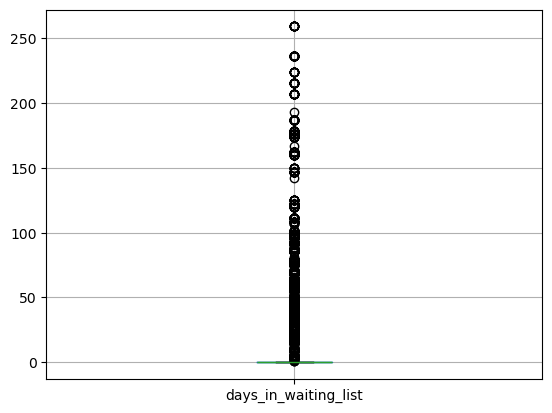

In [18]:
print('Показатели days_in_waiting_list для тренировочной выборки')
df_train.boxplot(column = 'days_in_waiting_list')
df_train['days_in_waiting_list'].describe()

In [19]:
print('Показатели days_in_waiting_list для тестовой выборки')
df_test.boxplot(column = 'days_in_waiting_list')
df_test['days_in_waiting_list'].describe()

Показатели days_in_waiting_list для тестовой выборки


count    32343.000000
mean         0.262901
std          4.738057
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        223.000000
Name: days_in_waiting_list, dtype: float64

75% заказов ожидали подтверждения 0 дней, т.е. сразу были подтвеждены, но так же есть некоторые случаи длительного ожидания, вплоть от 150 до 259 дней. Отбросим такие объекты.


In [20]:
df_train = df_train.query('days_in_waiting_list < 150')
df_test = df_test.query('days_in_waiting_list < 150')

#### Анализ прочих численных признаков

In [21]:
#Рассмотрим какие варианты количества ночей, взрослых, детей и младенцев встречаеются в наших данных
print('Данные для тренировочной выборки')
print('********************************************')
for col in ['total_nights', 'adults', 'children', 'babies']:
    print(df_train[col].unique())

Данные для тренировочной выборки
********************************************
[ 1  2  3  4  6  7  5  8 10  9]
[1 2 3 4]
[0 1 2 3]
[ 0  1  2 10  9]


Вопросики только к столбцу babies, количество младенцев в некоторых заказах 9 и 10. Возможно клиенты просто ошиблись при заполнении формы, исключим заказы с таким значениями.

In [22]:
df_train = df_train.query('babies <= 2')

In [23]:
print('Данные для тестовой выборки')
print('********************************************')
for col in ['total_nights', 'adults', 'children', 'babies']:
    print(df_test[col].unique())

Данные для тестовой выборки
********************************************
[ 1  4  7  2  5  6  3  8  9 10]
[2 1 3 4]
[0 2 1 3]
[0 1 2]


Тут все в пределах нормы.
__________________
**Промежуточный вывод:**

- На данном этапе работы мы проверили данные на корректность форматов, исправили где необходимо:
    - Поменяли тип на целочисленный, в столбцах с указанием количества гостей, детей, младенцев. А так же в графе с информацией о количестве дней между бронированием и заездом.
    - Для удобства дальнейшей работы изменили название месяцев на номера.
- Изучили период времени за который представлены данные
    - в тренировочных данных содержится информация о 65 228 заказах сделанных в период июль 2015 - декабрь 2016.
    - в тестовых информация о заказах с январь по июль 2017-го.
- Данные проверены на наличие пропусков и дубликатов, явных и неявных. Оных не обнаружено.

- Заказы проверены на выбросы:

     - Исключены заказы длительность подтверждения которых больше 150 дней.
     - Исключены заказы в которых количество младенцев 9 и 10.
     - Так же исключены заказы в которых нет ни одного взрослого.

## Исследовательский анализ.
### Общий анализ.

Рассмотрим распределение заказов по различным  признакам, 

In [24]:
#соединим 2 выборки в 1 датафрейм
df = pd.concat([df_train, df_test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97097 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id                              97097 non-null  int64 
 1   is_canceled                     97097 non-null  int64 
 2   lead_time                       97097 non-null  int64 
 3   arrival_date_year               97097 non-null  int64 
 4   arrival_date_month              97097 non-null  int64 
 5   arrival_date_week_number        97097 non-null  int64 
 6   arrival_date_day_of_month       97097 non-null  int64 
 7   stays_in_weekend_nights         97097 non-null  int64 
 8   stays_in_week_nights            97097 non-null  int64 
 9   adults                          97097 non-null  int64 
 10  children                        97097 non-null  int64 
 11  babies                          97097 non-null  int64 
 12  meal                            97097 non-null  obj

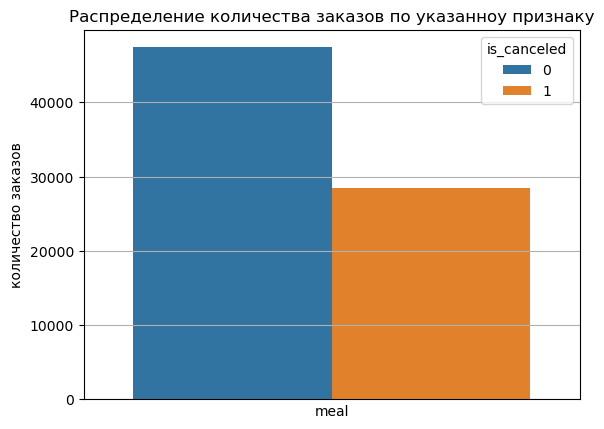

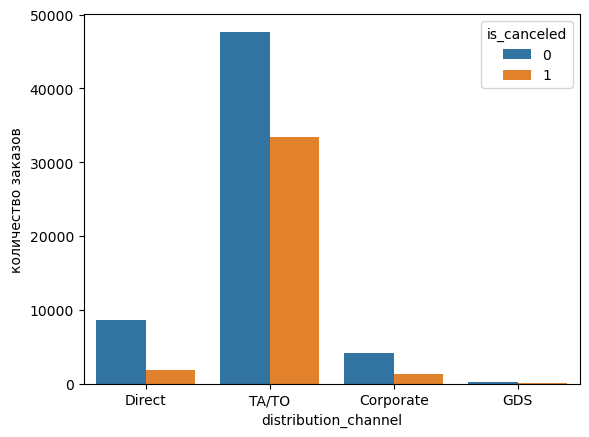

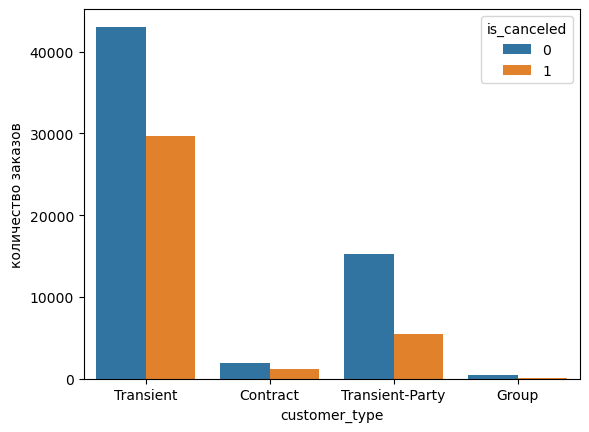

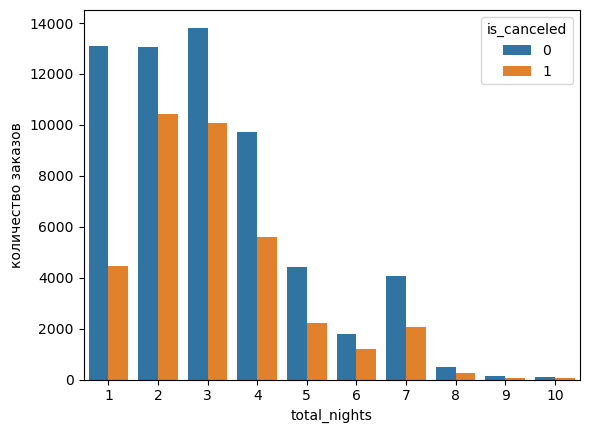

In [25]:
#для наглядности создадим гистограмы по каждому признаку
plt.title('Распределение количества заказов по указанноу признаку')
        
for col in ['meal', 'distribution_channel', 'customer_type', 'total_nights']:
    sns.countplot(data=df, x=col, hue='is_canceled')
    plt.ylabel('количество заказов')
    plt.show();

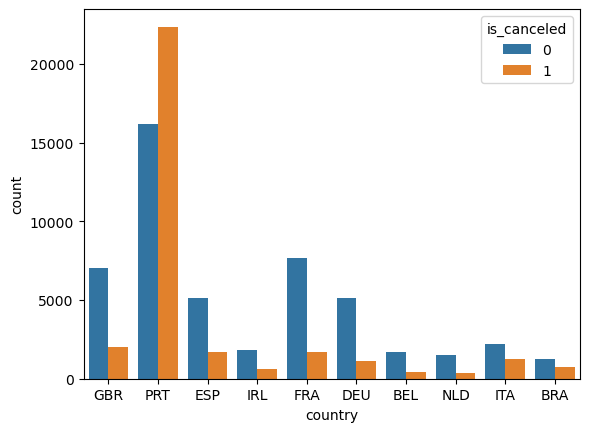

In [26]:
#из каких стран чаще всего поступают заказы
top_countries = df['country'].value_counts().head(10).index.tolist()
sns.countplot(data=df.query('country in @top_countries') , x='country', hue='is_canceled')
plt.show()
plt.xlabel('страна')
plt.ylabel('количество заказов');

Из данных графиков видно:
- Чаще прочих делают заказы с включенным завтраком. На втором месте, но в 3 раза реже встречается заказ без дополнительных опций. Самый непопулярный вариант это "включён завтрак, обед и ужин". Соотношение исполненных заказов пропорционально отмененным.

- Чаще всего заказы поступают через TA/TO. Самый непопулярный канал дистрируции "GDS". Соотношение исполненных заказов пропорционально отмененным.

- Самый популярное количество ночей для заказа 1-4, Заказы включающие 3 ночи, чаще других отменяются. Реже всего снимают номер на 8-10 ночей.

- Топ 3 по количеству заказов Португалия, Германия и Франция. Португальцы так же и самые непостоянные, отменяют заказы чаще, чем приезжают.


### Анализ прибыли

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

 В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:

* категория A: за ночь — 1 000, разовое обслуживание — 400;
* категория B: за ночь — 800, разовое обслуживание — 350;
* категория C: за ночь — 600, разовое обслуживание — 350;
* категория D: за ночь — 550, разовое обслуживание — 150;
* категория E: за ночь — 500, разовое обслуживание — 150;
* категория F: за ночь — 450, разовое обслуживание — 150;
* категория G: за ночь — 350, разовое обслуживание — 150.


В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

Напишем формулу для расчеты прибыли по каждому заказу.

In [27]:
#Изучим значения в ячейке которая будет опрелять стоимость услуг
print('Уникальные значения в тренировочной выборке')
print('********************************************')
for col in ['reserved_room_type', 'customer_type', 'distribution_channel', 'meal']:
    print(df_train[col].unique())

print()    
print('Уникальные значения в тестовой выборке')
print('********************************************')
for col in ['reserved_room_type', 'customer_type', 'distribution_channel', 'meal']:
    print(df_test[col].unique())

Уникальные значения в тренировочной выборке
********************************************
['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
['Transient' 'Contract' 'Transient-Party' 'Group']
['Direct' 'TA/TO' 'Corporate' 'GDS']
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']

Уникальные значения в тестовой выборке
********************************************
['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']
['Transient' 'Transient-Party' 'Contract' 'Group']
['TA/TO' 'Direct' 'Corporate' 'GDS']
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']


Значения в столбцах указаны некорректно 'meal' и 'reserved_room_type', слишком много пробелов, удалим их и проверим снова

In [28]:
#cоздадим цикл и пройдемся им по нужным нам столбцам, удаляя лишние пробелы
for df in [df_train, df_test]:
    for c in ['reserved_room_type', 'meal']:
        df[c] = df[c].str.replace(' ', '') 
        df[c] = df[c].str.strip()

#Проверяем
print('Уникальные значения в тренировочной выборке')
print('********************************************')
for col in ['reserved_room_type', 'meal']:
    print(df_train[col].unique())

print()    
print('Уникальные значения в тестовой выборке')
print('********************************************')
for col in ['reserved_room_type', 'meal']:
    print(df_test[col].unique())

Уникальные значения в тренировочной выборке
********************************************
['A' 'C' 'D' 'E' 'G' 'F' 'B']
['BB' 'FB' 'HB' 'SC']

Уникальные значения в тестовой выборке
********************************************
['A' 'E' 'G' 'D' 'F' 'C' 'B']
['BB' 'HB' 'SC' 'FB']


In [29]:

#Определим добавочные коэффициенты к стоимости в зависимости от сезона
season_low = [1, 2, 12]
season_mid = [3, 4, 5, 9, 10, 11]  
season_high = [6, 7, 8]

#Напишем функцию которая расчитает прибыль/убыток для каждого заказа
def revenue(row):
    #Дадим расшифровку к стоимости в зависимости от категории номера
    if row['reserved_room_type'] == 'A':
        price =  1000
        service = 400
    elif row['reserved_room_type'] == 'B':
        price =  800
        service = 350
    elif row['reserved_room_type'] == 'C':
        price =  600
        service = 350
    elif row['reserved_room_type'] == 'D':
        price =  550
        service = 150
    elif row['reserved_room_type'] == 'E':
        price =  500
        service = 150
    elif row['reserved_room_type'] == 'F':
        price =  450
        service = 150
    else:
        price =  350
        service = 150
    #Определим сезон и коэффициент
    if row['arrival_date_month'] in season_low:
        coefficient = 1
    elif row['arrival_date_month'] in season_mid:
        coefficient = 1.2
    elif row['arrival_date_month'] in season_high:
        coefficient = 1.4
   #Рассчитаем прибыль
    if row['is_canceled'] == 1:
        return -(price * coefficient + service)
    else:
        return price *  coefficient * row['total_nights'] - ((1 + row['total_nights'] // 2) * service)
#Создадим новый столец с учетом стоимости заказа для хозяев отеля    
df_train['profit'] = df_train.apply(revenue, axis=1)
df_test['profit'] = df_test.apply(revenue, axis=1)  
#Посмотрим насколько корректно работает наша фунция 
df_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,profit
0,0,0,7,2015,7,27,1,0,1,1,...,0,0,A,0,0,Transient,0,0,1,1000.0
1,1,0,14,2015,7,27,1,0,2,2,...,0,0,A,0,0,Transient,0,1,2,2000.0
2,2,0,0,2015,7,27,1,0,2,2,...,0,0,C,0,0,Transient,0,0,2,980.0
3,3,0,9,2015,7,27,1,0,2,2,...,0,0,C,0,0,Transient,0,1,2,980.0
4,4,1,85,2015,7,27,1,0,3,2,...,0,0,A,0,0,Transient,0,1,3,-1800.0


Функция работает корректно

#### 2015-й год

Рассмотрим показатели количества и приыбли заяввок по годам.

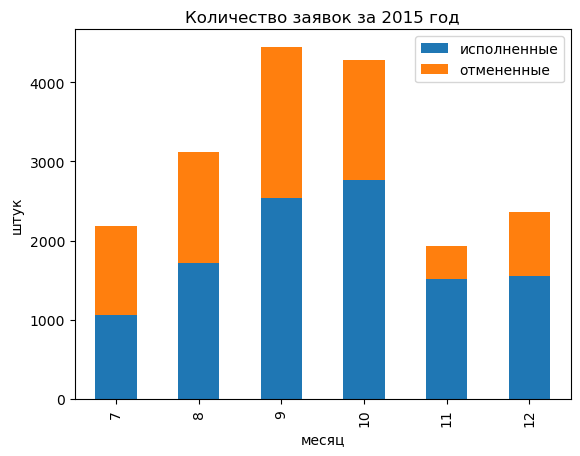

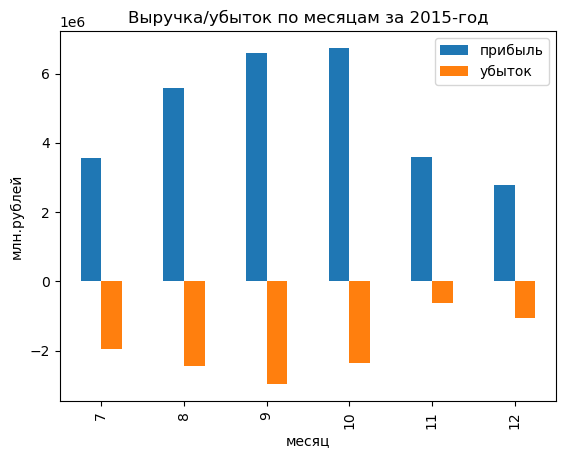

In [31]:
#Создадим график в котором отразим количество заявок по месяцам

year_2015 = df_train.query('arrival_date_year == 2015').pivot_table(index='arrival_date_month', 
                                                                    columns='is_canceled', 
                                                                    values='profit', 
                                                                    aggfunc='count')
year_2015.columns = ['исполненные', 'отмененные']
year_2015.plot(kind='bar', 
               stacked=True,
               title='Количество заявок за 2015 год',
               ylabel = 'штук',
               xlabel = 'месяц')
plt.show()

#Создадим график в котором отразим выручку и убыток от заказов по месяцам
year_2015 = df_train.query('arrival_date_year == 2015').pivot_table(index='arrival_date_month', columns='is_canceled', values='profit', aggfunc='sum')
year_2015.columns = ['прибыль', 'убыток']
year_2015.plot(kind='bar', 
               title='Выручка/убыток по месяцам за 2015-год',
               ylabel = 'млн.рублей',
               xlabel = 'месяц')
plt.show()

In [32]:
#Создадим на основе нашего датафрейма сводную таблицу в которой отобразим информацию по 
#отмененным и исполненным заказам
total_2015 = df_train.query('arrival_date_year == 2015').pivot_table(index='arrival_date_month',
                                                                     columns='is_canceled',
                                                                     values='profit',
                                                                     aggfunc=['sum', 'count'])
total_2015 = total_2015.droplevel(1, axis=1).reset_index()

total_2015.columns = ['месяц заезда', 'доход от исполненных заказов', 
                      'убыток от отмененных заказов', 'количество исполненных заказов',
                      'количество отмененных закaзов']
#посчитаем общее количество заказов и выведе это в отдельный столбец
total_2015['всего заказов'] = total_2015['количество исполненных заказов'] + total_2015['количество отмененных закaзов']
#расчитаем прибыль с вычетом убытков
total_2015['прибыль с вычетом убытков'] = total_2015['доход от исполненных заказов'] + total_2015['убыток от отмененных заказов']
#отдельно выделим долю убытков
total_2015['доля отмененных заказов'] = round(total_2015['количество отмененных закaзов'] / 
                                              (total_2015['количество отмененных закaзов'] + 
                                               total_2015['количество исполненных заказов']) * 100, 2)
#расчитаем общие показатели за год
total_2015.loc[6] = ['Итого',
    total_2015['доход от исполненных заказов'].sum(),
    total_2015['убыток от отмененных заказов'].sum(),
    total_2015['количество исполненных заказов'].sum(),
    total_2015['количество отмененных закaзов'].sum(),
    total_2015['всего заказов'].sum(),
    total_2015['прибыль с вычетом убытков'].sum(),
    round(total_2015['количество отмененных закaзов'].sum() / 
          (total_2015['количество отмененных закaзов'].sum() + total_2015['количество исполненных заказов'].sum()) * 100, 2)]

In [33]:
total_2015

,месяц заезда,доход от исполненных заказов,убыток от отмененных заказов,количество исполненных заказов,количество отмененных закaзов,всего заказов,прибыль с вычетом убытков,доля отмененных заказов
0,7,3560840.0,-1947940.0,1055,1130,2185,1612900.0,51.72
1,8,5592910.0,-2452320.0,1710,1403,3113,3140590.0,45.07
2,9,6597090.0,-2969890.0,2533,1910,4443,3627200.0,42.99
3,10,6734690.0,-2366000.0,2767,1514,4281,4368690.0,35.37
4,11,3587900.0,-632310.0,1514,415,1929,2955590.0,21.51
5,12,2795050.0,-1067950.0,1547,816,2363,1727100.0,34.53
6,Итого,28868480.0,-11436410.0,11126,7188,18314,17432070.0,39.25


 **АНАЛИТИКА ПО 2015-му ГОДУ:**

- За 2015-й год доход от исполненных заказов составил 28 868 480 руб, с вычетом убытков от отмененных заказов (а это 11 436 410 рублей) 17 432 070 .

- Заказов за этот перод время было 18314, 39% из них, то есть 7188 были отменены

- Самый прибыльный месяц с июля по декабрь - октябрь 4 368 690 руб

- Самая маленькая прибыль обозначенного периода за декабрь 1 727 100 руб.


#### 2016-й год

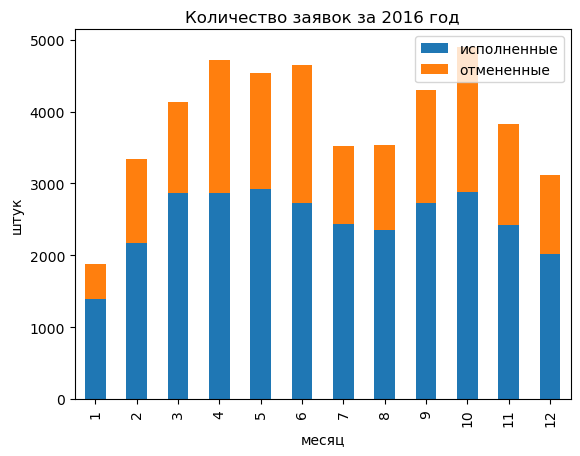

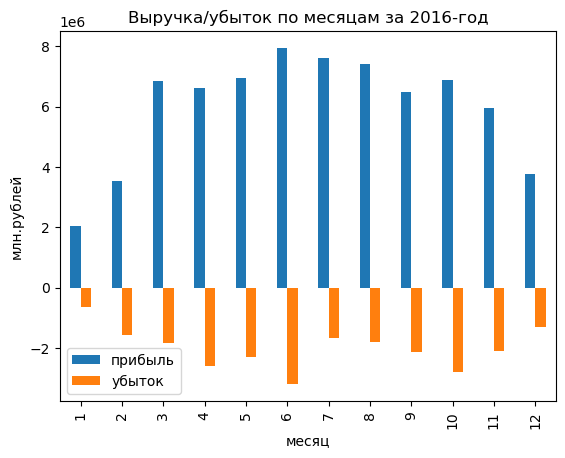

In [34]:
#Создадим график в котором отразим количество заявок по месяцам
year_2016 = df_train.query('arrival_date_year == 2016').pivot_table(index='arrival_date_month',
                                                                    columns='is_canceled', 
                                                                    values='profit', 
                                                                    aggfunc='count')
year_2016.columns = ['исполненные', 'отмененные']
year_2016.plot(kind='bar', 
               stacked=True,
               title='Количество заявок за 2016 год',
               ylabel = 'штук',
               xlabel = 'месяц')
plt.show()

#Создадим график в котором отразим выручку убыток от заказов по месяцам
year_2016 = df_train.query('arrival_date_year == 2016').pivot_table(index='arrival_date_month', columns='is_canceled', values='profit', aggfunc='sum')
year_2016.columns = ['прибыль', 'убыток']
year_2016.plot(kind='bar', 
               title='Выручка/убыток по месяцам за 2016-год',
               ylabel = 'млн.рублей',
               xlabel = 'месяц')
plt.show()

In [35]:
#Создадим на основе нашего датафрейма сводную таблицу в которой отобразим информацию по 
#отмененным и исполненным заказам
total_2016 = df_train.query('arrival_date_year == 2016').pivot_table(index='arrival_date_month',
                                                                     columns='is_canceled',
                                                                     values='profit',
                                                                     aggfunc=['sum', 'count'])
total_2016 = total_2016.droplevel(1, axis=1).reset_index()

total_2016.columns = ['месяц заезда', 'доход от исполненных заказов', 
                      'убыток от отмененных заказов', 'количество исполненных заказов',
                      'количество отмененных закaзов']
#посчитаем общее количество заказов и выведе это в отдельный столбец
total_2016['всего заказов'] = total_2016['количество исполненных заказов'] + total_2016['количество отмененных закaзов']
#расчитаем прибыль с вычетом убытков
total_2016['прибыль с вычетом убытков'] = total_2016['доход от исполненных заказов'] + total_2016['убыток от отмененных заказов']
#отдельно выделим долю убытков
total_2016['доля отмененных заказов'] = round(total_2016['количество отмененных закaзов'] / 
                                              (total_2016['количество отмененных закaзов'] + 
                                               total_2016['количество исполненных заказов']) * 100, 2)
#расчитаем общие показатели за год
total_2016.loc[12] = ['Итого',
    total_2016['доход от исполненных заказов'].sum(),
    total_2016['убыток от отмененных заказов'].sum(),
    total_2016['количество исполненных заказов'].sum(),
    total_2016['количество отмененных закaзов'].sum(),
    total_2016['всего заказов'].sum(),
    total_2016['прибыль с вычетом убытков'].sum(),
    round(total_2016['количество отмененных закaзов'].sum() / 
          (total_2016['количество отмененных закaзов'].sum() + total_2016['количество исполненных заказов'].sum()) * 100, 2)]

In [36]:
total_2016

,месяц заезда,доход от исполненных заказов,убыток от отмененных заказов,количество исполненных заказов,количество отмененных закaзов,всего заказов,прибыль с вычетом убытков,доля отмененных заказов
0,1,2042100.0,-638000.0,1396,485,1881,1404100.0,25.78
1,2,3547650.0,-1564850.0,2165,1179,3344,1982800.0,35.26
2,3,6866140.0,-1826310.0,2866,1272,4138,5039830.0,30.74
3,4,6636390.0,-2598880.0,2865,1850,4715,4037510.0,39.24
4,5,6951080.0,-2292750.0,2920,1616,4536,4658330.0,35.63
5,6,7940690.0,-3200050.0,2722,1929,4651,4740640.0,41.47
6,7,7624360.0,-1674040.0,2430,1086,3516,5950320.0,30.89
7,8,7417830.0,-1813390.0,2348,1186,3534,5604440.0,33.56
8,9,6472630.0,-2136380.0,2733,1565,4298,4336250.0,36.41
9,10,6888010.0,-2800810.0,2883,2017,4900,4087200.0,41.16


 **АНАЛИТИКА ПО 2016-му ГОДУ:**

- За 2016-й год доход от исполненных заказов составил 72 102 010 руб, с вычетом убытков от отмененных заказов (а это 23 951 970 рублей) 48 150 040.

- Заказов за этот перод время было 46 448, 35.9% из них, то есть 16 681 были отменены

- Самый прибыльным периодом ожидаемо оказалось лето, самый топовый месяц - июль прибыль 5 950 320 руб

- Самая маленькая прибыль обозначенного периода за январь 1 404 100 руб.


#### 2017-1 год

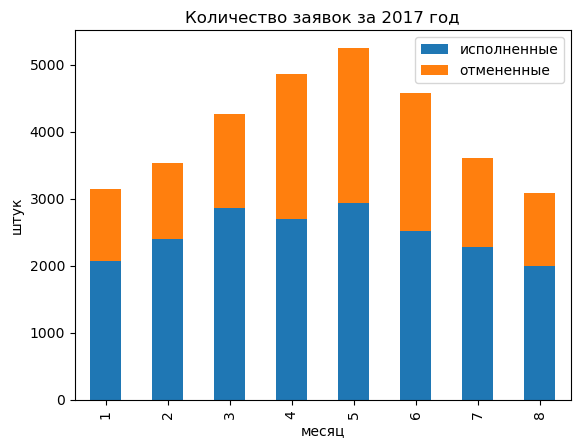

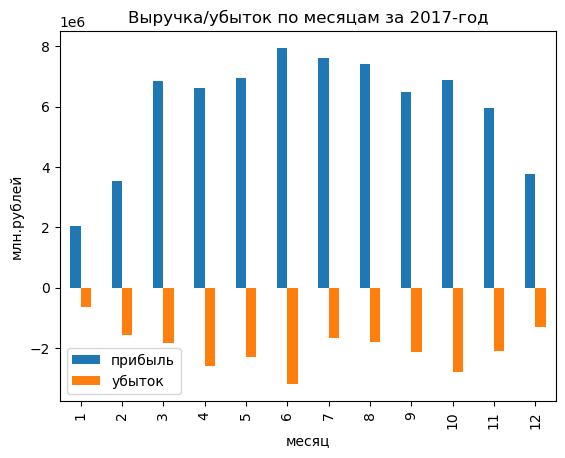

In [37]:
#Создадим график в котором отразим количество заявок по месяцам
year_2017 = df_test.query('arrival_date_year == 2017').pivot_table(index='arrival_date_month',
                                                                    columns='is_canceled', 
                                                                    values='profit', 
                                                                    aggfunc='count')
year_2017.columns = ['исполненные', 'отмененные']
year_2017.plot(kind='bar', 
               stacked=True,
               title='Количество заявок за 2017 год',
               ylabel = 'штук',
               xlabel = 'месяц')
plt.show()

#Создадим график в котором отразим выручку убыток от заказов по месяцам
year_2017 = df_train.query('arrival_date_year == 2016').pivot_table(index='arrival_date_month',
                                                                    columns='is_canceled', 
                                                                    values='profit', 
                                                                    aggfunc='sum')
year_2017.columns = ['прибыль', 'убыток']
year_2017.plot(kind='bar', 
               title='Выручка/убыток по месяцам за 2017-год',
               ylabel = 'млн.рублей',
               xlabel = 'месяц')
plt.show()

In [38]:
#Создадим на основе нашего датафрейма сводную таблицу в которой отобразим информацию по 
#отмененным и исполненным заказам
total_2017 = df_test.query('arrival_date_year == 2017').pivot_table(index='arrival_date_month',
                                                                     columns='is_canceled',
                                                                     values='profit',
                                                                     aggfunc=['sum', 'count'])
total_2017 = total_2017.droplevel(1, axis=1).reset_index()

total_2017.columns = ['месяц заезда', 'доход от исполненных заказов', 'убыток от отмененных заказов', 'количество исполненных заказов','количество отмененных закaзов']

total_2017['всего заказов'] = total_2017['количество исполненных заказов'] + total_2017['количество отмененных закaзов']

total_2017['прибыль с вычетом убытков'] = total_2017['доход от исполненных заказов'] + total_2017['убыток от отмененных заказов']

total_2017['доля отмененных заказов'] = round(total_2017['количество отмененных закaзов'] / 
                                              (total_2017['количество отмененных закaзов'] + 
                                               total_2017['количество исполненных заказов']) * 100, 2)
total_2017.loc[8] = ['Итого',
    total_2017['доход от исполненных заказов'].sum(),
    total_2017['убыток от отмененных заказов'].sum(),
    total_2017['количество исполненных заказов'].sum(),
    total_2017['количество отмененных закaзов'].sum(),
    total_2017['всего заказов'].sum(),
    total_2017['прибыль с вычетом убытков'].sum(),
    round(total_2017['количество отмененных закaзов'].sum() / 
          (total_2017['количество отмененных закaзов'].sum() + total_2017['количество исполненных заказов'].sum()) * 100, 2)]

In [39]:
total_2017

,месяц заезда,доход от исполненных заказов,убыток от отмененных заказов,количество исполненных заказов,количество отмененных закaзов,всего заказов,прибыль с вычетом убытков,доля отмененных заказов
0,1,3516650.0,-1348800.0,2073,1069,3142,2167850.0,34.02
1,2,4320950.0,-1400250.0,2406,1131,3537,2920700.0,31.98
2,3,6997610.0,-1947880.0,2860,1405,4265,5049730.0,32.94
3,4,7155050.0,-3026870.0,2696,2165,4861,4128180.0,44.54
4,5,7128140.0,-3268750.0,2944,2309,5253,3859390.0,43.96
5,6,7676870.0,-3313800.0,2522,2052,4574,4363070.0,44.86
6,7,7019890.0,-2020020.0,2284,1326,3610,4999870.0,36.73
7,8,6679320.0,-1669500.0,1993,1100,3093,5009820.0,35.56
8,Итого,50494480.0,-17995870.0,19778,12557,32335,32498610.0,38.83


 **АНАЛИТИКА ПО 2017-му ГОДУ:**

- За первое полугодие 2017-го года доход от исполненных заказов составил 50 494 480 руб, с вычетом убытков от отмененных заказов (а это 17 995 870 рублей) 32 498 610.

- Заказов за этот перод времени было 32335, 38,8% из них, то есть 12 557 были отменены

- Самый прибыльным  месяцем оказался март, прибыль 5 049 730 руб.

- Самая маленькая прибыль обозначенного периода  - январь  2 167 850 руб.


____________

**Промежуточный вывод:**


- Проведен анализ составлен график заказов по таким признакам как страна, длительность заезда, канал дистрибуции и какие дополнительно заказанным опциям.

    * Чаще прочих делают заказы с включенным завтраком. На втором месте, но в 3 раза реже встречается заказ без дополнительных опций. Самый непопулярный вариант это "включён завтрак, обед и ужин". Соотношение исполненных заказов пропорционально отмененным.

    * Чаще всего заказы поступают через TA/TO. Самый непопулярный канал дистрируции "GDS". Соотношение исполненных заказов пропорционально отмененным.

    * Самый популярное количество ночей для заказа 1-4, Заказы включающие 3 ночи, чаще других отменяются. Реже всего снимают номер на 8-10 ночей.   

    * Топ 3 по количеству заказов Португалия, Германия и Франция. Португальцы так же и самые непостоянные, отменяют заказы чаще, чем приезжают.
 
      
- Далее мы написали функцию которая расчитала прибыль от всех заказов, положительную от исполненных и отрицательную от отененных.
  
- Затем с использованием этих данных мы сделали сводную таблицу в которой был указана суммарная доход и убыток по месяцам, а так же дополнили столбцами с расчитанными значениями:
    - общее количество всех заказов
    - доля отмененных заказов и всех
    - прибыль с вычетом убытков
- Полученнные данные были проанализированы

  **АНАЛИТИКА ПО 2015-му ГОДУ:**

   - За 2015-й год доход от исполненных заказов составил 28 868 480 руб, с вычетом убытков от отмененных заказов (а это 11 436 410 рублей) 17 432 070 .

   - Заказов за этот перод время было 18314, 39% из них, то есть 7188 были отменены

   - Самый прибыльный месяц с июля по декабрь - октябрь 4 368 690 руб

   - Самая маленькая прибыль обозначенного периода за декабрь 1 727 100 руб.
    
  **АНАЛИТИКА ПО 2016-му ГОДУ:**

   - За 2016-й год доход от исполненных заказов составил 72 102 010 руб, с вычетом убытков от отмененных заказов (а это 23 951 970 рублей) 48 150 040.

   - Заказов за этот перод время было 46 448, 35.9% из них, то есть 16 681 были отменены

   - Самый прибыльным периодом ожидаемо оказалось лето, самый топовый месяц - июль прибыль 5 950 320 руб

   - Самая маленькая прибыль обозначенного периода за январь 1 404 100 руб.

  **АНАЛИТИКА ПО 2017-му ГОДУ:**

   - За первое полугодие 2017-го года доход от исполненных заказов составил 50 494 480 руб, с вычетом убытков от отмененных заказов (а это 17 995 870 рублей) 32 498 610.

   - Заказов за этот перод времени было 32335, 38,8% из них, то есть 12 557 были отменены

   - Самый прибыльным  месяцем оказался март, прибыль 5 049 730 руб.

   - Самая маленькая прибыль обозначенного периода  - январь  2 167 850 руб.


## Работа с машинным обучением

###  Формулировка ML-задачи на основе бизнес-задачи

   Из года в год очень отели несут огромные (от 11 до 18 млн в полгода) убытки от отменненных заказов.

   Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

   На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.



In [40]:
#Объявим константы которые нам потребуются для дальнейших расчетов
price_system = 400000 #Стоимость системы предсказывающий отказ от брони
coefficient_deposit = 0.8 #Коэффициент, помогающий расчитать стоимость депозита (80% от стоимости ночи и разовой уборки)

### Подготовка данных для обучения модели

Подготовим данные для разработки модели. 

Все данные изначально поделены на обучащие и тестовые, тренировочная выборка приблизительно в 2 раза больше тестовой. Очень удобно.

Теперь выделим отдельно цель, это признак объекта is_canceled, именно он показывает нам отменен заказ или нет.

Для обучения модели, нам не понадобятся данные id и  profit, исключим их

In [41]:
features_train = df_train.drop(['id', 'profit', 'is_canceled'], axis = 1)
target_train = df_train['is_canceled']
features_test = df_test.drop(['id', 'profit', 'is_canceled'], axis = 1)
target_test = df_test['is_canceled']

Данные представленные НЕчисловыми значениями, представлены в столбцах 'meal','country','distribution_channel', 'reserved_room_type', 'customer_type'.

Их нам и нужно преобразовать. 
Воспользуемся для этого методом OHE-кодирования.

Признак is_repeated_guest  являeтся бинарными, его оставляем без изменения.

Остальные численные признаки нужно стандартизировать для корректной работы модели.

In [42]:
#создаем список категориальных признаков
ohe_features = features_train.select_dtypes(include='object').columns.to_list()

#численные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
#удаляем бинарные признаки
num_features.remove('is_repeated_guest')


# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
# задаём handle_unknown='ignore':
# игнорируется ранее невстречающиеся значения признака (при transform)
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в 
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[encoder_ohe.get_feature_names_out(ohe_features)] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

#импортируем объект стандартизации
scaler = StandardScaler()

# обучаем его на численных признаках тренировочной выборки, трансформируем её же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.926400,-1.592546,-0.147593,-0.324688,-1.697334,-0.967314,-0.900732,-1.781255,-0.219764,-0.083093,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.853086,-1.592546,-0.147593,-0.324688,-1.697334,-0.967314,-0.162421,0.336526,-0.219764,-0.083093,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.999713,-1.592546,-0.147593,-0.324688,-1.697334,-0.967314,-0.162421,0.336526,-0.219764,-0.083093,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.905453,-1.592546,-0.147593,-0.324688,-1.697334,-0.967314,-0.162421,0.336526,-0.219764,-0.083093,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.109476,-1.592546,-0.147593,-0.324688,-1.697334,-0.967314,0.575890,0.336526,-0.219764,-0.083093,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [43]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64762 entries, 0 to 65228
Columns: 187 entries, lead_time to customer_type_Transient-Party
dtypes: float64(186), int64(1)
memory usage: 92.9 MB


In [44]:
#Таким же образом преобразуем данные из тестового массива
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])
features_test = features_test.drop(ohe_features, axis=1)

features_test[num_features] = scaler.transform(features_test[num_features])

/Users/mariaspartalan/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [45]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32335 entries, 0 to 32411
Columns: 187 entries, lead_time to customer_type_Transient-Party
dtypes: float64(186), int64(1)
memory usage: 46.4 MB


###  Разработка модели ML


Создадим несколько моделей, для предсказания значения is_canceled, этот признак указывает на это был ли заказ отменен или исполнен.
Для оценки качества модели можно использовать метрики  recall, precision и f1.

Первая покажет нам насколько охотно модель обпределят обект как 1. То есть, чем она выше, тем чаще модель отмечает все как 1. Выбрав модель с максимальным Recall, мы выберем модель которая будет заставлять макимальное количество людей вносить депозит? тем самые сведет потери от отмененных заказов к минимуму.

Показатель precission покажет нам насколько точно модель определят значение отмены заказов, то есть чем она выше, тем меньше не верных положительных предсказаний, то есть меньшее количество заказов будет с депозитами, тут мы можем просеть по прибыли.

f1 это среднегармоническое этиъ двух метрик.
Остановимся на первом, recall.

#### Модель - Линейная регрессия

In [46]:
#Инициируем и обучаем модель, вычисляем f1 для нее
lr = LogisticRegression(solver='liblinear', random_state=state)
lr.fit(features_train, target_train)
predicted = lr.predict(features_test)
scores = cross_val_score(lr, features_train, target_train, cv=5, scoring='recall')
print('Средний показатель recall качества линейной регрессии', scores.sum() / len(scores))

Средний показатель recall качества линейной регрессии 0.5671361768135962


#### Модель - Дерево решений

In [47]:
best_depth = 0
best_score = 0

for depth  in range(1, 30):
    tree = DecisionTreeClassifier(max_depth = depth, random_state=state)
    tree.fit(features_train, target_train)
    scores = cross_val_score(tree, features_train, target_train, cv=5, scoring='recall')
    final_score = scores.sum() / len(scores)
    if final_score > best_score:
        best_score = final_score
        best_depth = depth
        
print('Лучший средний показатель recall {} показало дерево глубиной {}'.format(best_score, best_depth))

Лучший средний показатель recall 0.5321093260328069 показало дерево глубиной 4


#### Модель - Лес Случайных Деревьев

In [48]:
best_est = 0
best_depth = 0
best_score = 0

for est in (1, 150, 4):
    for depth in (1, 21):
        forest = RandomForestClassifier(max_depth = depth, n_estimators = est, random_state = state)
        forest.fit(features_train, target_train)
        scores = cross_val_score(forest, features_train, target_train, cv=5, scoring='recall')
        final_score = scores.sum() / len(scores)
        if final_score > best_score:
            best_score = final_score
            best_est = est
            best_depth = depth
            

print('Лучший средний показатель recall:', best_score)
print('Глубина для лучшей модели:', best_depth)
print('Количество деревьев для лучшей модели:', best_est)

Лучший средний показатель recall: 0.5034138755819175
Глубина для лучшей модели: 21
Количество деревьев для лучшей модели: 1


#### Баланс/Дисбаланс классов

Выше в работе мы увидели что исполненных заказов бльше, чем отмененных, уточним как эти величины друг к другу относятся и попробуем поиграть с балансом, создать модель для каждой новой выборки, рассчитать f1 и выбрать лучше всего обученнную модель.


In [49]:

class_frequency = df_train['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Cоотношение значений целевого признака');

is_canceled
0    0.631435
1    0.368565
Name: proportion, dtype: float64


is_canceled
0    0.611659
1    0.388341
Name: proportion, dtype: float64


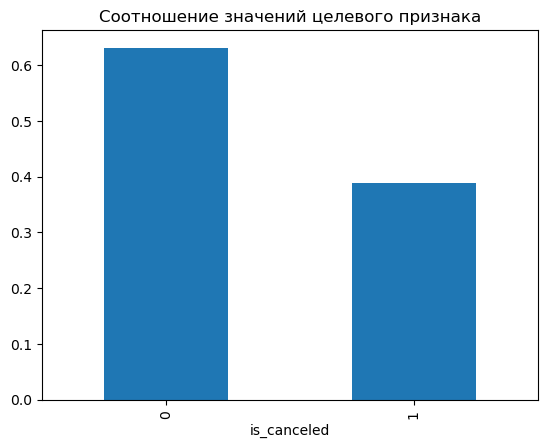

In [50]:

class_frequency = df_test['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.title('Cоотношение значений целевого признака')
plt.show();

In [51]:
features_zeros = features_train[target_train == 0] 
target_zeros = target_train[target_train == 0] 

features_ones = features_train[target_train == 1]
target_ones = target_train[target_train == 1]

print('Отрицательных значений', target_zeros.shape[0])
print()
print('Положительных значений', target_ones.shape[0])

Отрицательных значений 40893

Положительных значений 23869


In [52]:
print('Положительные значения целевого признака встречаются в {} раза меньше, чем отрицательные'.format(
    round(target_zeros.shape[0]/target_ones.shape[0], 1)))

Положительные значения целевого признака встречаются в 1.7 раза меньше, чем отрицательные


Учитывая выявленный выше дисбаланс, сделаем пайплайн для  увеличения миноритарного класса. Далее вызовем модель, дадим оценку recall для каждой выборки полученной в ходе кросс валидации, высчитаем среднюю. 

In [53]:
kf = KFold(n_splits=5, random_state=state, shuffle=True)

In [54]:
#Линейная регрессия
imba_pipeline = make_pipeline(SMOTE(random_state=state), 
                              LogisticRegression(solver='liblinear', random_state=state))
cv_ups_score = cross_val_score(imba_pipeline, features_train, target_train, scoring='recall', cv=kf)
print('Средний recall линейной регрессии на увеличенной выборке = ', cv_ups_score.sum() / len(cv_ups_score))

Средний recall линейной регрессии на увеличенной выборке =  0.7585075925321085


In [55]:
#Дерево решений
imba_pipeline = make_pipeline(SMOTE(random_state=state), 
                              DecisionTreeClassifier(max_depth = 25, random_state=state))
cv_vp_tree_recall = cross_val_score(imba_pipeline, features_train, target_train, scoring='recall', cv=kf)
print('Средний recall дерева на увеличенной выборке = ', cv_vp_tree_recall.sum() / len(cv_vp_tree_recall))


Средний recall дерева на увеличенной выборке =  0.8161390337224914


In [56]:
#Теперь вычислим лучшие параметры дерева
params = {'max_depth': [4, 6, 10, 12]}


new_params = {'decisiontreeclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_imba.fit(features_train, target_train);

In [57]:
print('Параметры лучшего дерева', grid_imba.best_params_)
print('______________________________')
print('Его лучший результат', grid_imba.best_score_)

Параметры лучшего дерева {'decisiontreeclassifier__max_depth': 12}
______________________________
Его лучший результат 0.8174896755404706


In [58]:
best_model = DecisionTreeClassifier(max_depth=12, random_state=state).fit(features_train, target_train)

In [59]:
#Лес деревьев
imba_pipeline = make_pipeline(SMOTE(random_state=state), 
                              RandomForestClassifier(n_estimators=100, random_state=state))
cv_vp_forest_recall = cross_val_score(imba_pipeline, features_train, target_train, scoring='recall', cv=kf)
print('Средний recall леса на увеличенной выборке = ', cv_vp_forest_recall.sum() / len(cv_vp_forest_recall))

Средний recall леса на увеличенной выборке =  0.8038522084370217


In [60]:
#Лучшие параметры
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12]
}


new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_imba.fit(features_train, target_train);

In [61]:
print('Параметры лучшего леса', grid_imba.best_params_)
print('______________________________')
print('Его лучший результат', grid_imba.best_score_)

Параметры лучшего леса {'randomforestclassifier__max_depth': 12, 'randomforestclassifier__n_estimators': 200}
______________________________
Его лучший результат 0.7838035515616918


**Средний recall на различных выборках**



| Модель                     | Несблансированная выборка| Увеличенный минор |
|----------------------------|--------------------------|-------------------|
| Логистическая регрессия    |          0.567          |       0.759      | 
| Дерево решений             |          0.532           |      **0.816**      | 
| Лес случайных деревьев     |          0.503           |       0.804      |

Лучше всех себя показало дерево на увеличенной выбоке, сохраним эти параметры и модель для дальнейшей работы.


In [62]:
predicted = best_model.predict(features_test)
print('recall дучшей модели на тестовой выборке', recall_score(target_test, predicted))


recall дучшей модели на тестовой выборке 0.5338854822011627


In [63]:
predicted = pd.Series(predicted)
df_test['predicted'] = predicted

In [64]:
def deposit(row):
    if row['reserved_room_type'] == 'A':
        price =  1000
        service = 400
    elif row['reserved_room_type'] == 'B':
        price =  800
        service = 350
    elif row['reserved_room_type'] == 'C':
        price =  600
        service = 350
    elif row['reserved_room_type'] == 'D':
        price =  550
        service = 150
    elif row['reserved_room_type'] == 'E':
        price =  500
        service = 150
    elif row['reserved_room_type'] == 'F':
        price =  450
        service = 150
    else:
        price =  350
        service = 150
    #Определим сезон и коэффициент
    if row['arrival_date_month'] in season_low:
        coefficient = 1
    elif row['arrival_date_month'] in season_mid:
        coefficient = 1.2
    elif row['arrival_date_month'] in season_high:
        coefficient = 1.4
    #Hасчитываем сумму депозита
    if row['predicted'] == 0:
        return 0
    if row['predicted'] == 1:
        return (price * coefficient  + service)  * coefficient_deposit

In [65]:
df_test['deposit'] = df_test.apply(deposit, axis=1)
df_test.head(10)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,profit,predicted,deposit
0,6086,1,74,2017,1,1,1,1,0,2,...,A,0,0,Transient,0,0,1,-1400.0,1.0,1120.0
1,6087,1,62,2017,1,1,1,2,2,2,...,A,0,0,Transient,0,1,4,-1400.0,0.0,0.0
2,6088,1,62,2017,1,1,1,2,2,2,...,A,0,0,Transient,0,1,4,-1400.0,0.0,0.0
3,6089,1,71,2017,1,1,1,2,2,1,...,A,0,0,Transient,0,1,4,-1400.0,0.0,0.0
4,6090,1,172,2017,1,1,1,2,5,2,...,A,0,0,Transient,0,0,7,-1400.0,0.0,0.0
5,6091,1,52,2017,1,1,1,2,5,1,...,A,0,0,Transient,0,0,7,-1400.0,0.0,0.0
6,6092,1,143,2017,1,1,2,1,1,2,...,A,1,0,Transient,0,1,2,-1400.0,0.0,0.0
7,6093,1,21,2017,1,1,2,1,3,2,...,A,0,0,Transient,0,1,4,-1400.0,0.0,0.0
8,6094,1,89,2017,1,1,2,1,3,2,...,E,0,0,Transient,0,0,4,-650.0,0.0,0.0
9,6095,1,48,2017,1,1,2,1,4,2,...,A,1,0,Transient,0,2,5,-1400.0,1.0,1120.0


Теперь напишем функцию которая посчитает прибыль после введения новой системы предсказаний отомен и обязательных депозитов.

In [66]:
def profit_b(row):
    if row['predicted'] == 0:
        return row['profit']
    else:
        if row['is_canceled'] == 0:
            return row['profit']
        else:
            return row['profit'] + row['deposit']
    
df_test['profit_b'] = df_test.apply(profit_b, axis=1)

In [67]:
#посчитаем разницу прибылей в тестовый период доввеления новшеств и после
print('После введения системы обязательных депозитов выручка изменилась на',  df_test['profit_b'].sum() - df_test['profit'].sum())

После введения системы обязательных депозитов выручка изменилась на 7840960.0


Разница в прибыли с внедрением системы составляет больше 7.8 млн рублей.
     Это во много раз больше затраченнных на производство 400 000 рублей

**Промежуточный вывод:**

На данном этапе работы были изучены модели:
- линейная регрессия
- дерево решений
- лес случайных моделей

Для каждой были подобораны параметры, при которых модель показывала лучший результат.

Далее был выявлен дисбаланс классов. И была разработана модель на выборке увеличенной по мироториному признаку
Для каждой подобраны лучшие параметры и расчитан индивидуальный recall.
дерево решений обученнная на увеченной подборке.

**Показатели recall на различных выборках**


| Модель                     | Несблансированная выборка| Увеличенный минор |
|----------------------------|--------------------------|-------------------|
| Логистическая регрессия    |          0.567          |       0.759      | 
| Дерево решений             |          0.532           |      **0.816**      | 
| Лес случайных деревьев     |          0.503           |       0.804      |


Предсказанные ею значения добавлены в таблицу с тестовыми данными. Но основании их расчитан обязательный депозит, с учетом этого рассчитана прибыль отеля после внедрения новшеств.

Разница в прибыли с внедрением системы составляет больше 7.8  млн рублей.

Это во много раз больше затраченнных на производство 400 000 рублей. 


###  Опишем портрет «ненадёжного» клиента

In [68]:
#Выберем столбцы, распределения в которых будем изучать
analize_columns = (
    df
    .drop([
    'id', 'is_canceled','arrival_date_year', 'profit', 'predicted', 'deposit', 'profit_b' ], axis = 1)
    .columns
    .to_list()
)

#Сгруппируем все значения по значению отмены и посмотрим, насколько равномерно распределяются топовые признаки
for col in analize_columns:
    print(df.groupby('is_canceled')[col].value_counts().head(5))
    print()
    print('********************************')
    print()

is_canceled  lead_time
0            0            1296
             1             736
             2             441
             3             367
             4             359
Name: count, dtype: int64

********************************

is_canceled  arrival_date_month
0            5                     2944
             3                     2860
             4                     2696
             6                     2522
             2                     2406
Name: count, dtype: int64

********************************

is_canceled  arrival_date_week_number
0            21                          720
             8                           704
             17                          684
             18                          680
             10                          669
Name: count, dtype: int64

********************************

is_canceled  arrival_date_day_of_month
0            2                            763
             9                            734
             

In [69]:
table = pd.pivot_table(
    df,
    values = ['arrival_date_year', 'profit', 'predicted', 'deposit', 'profit_b'],
    index='is_canceled', 
    aggfunc = 'count')



* много (почти каждый 3-й заказ) отмен встречается в заказах без детей.

* много (почти каждый 3 заказ) отмен встречается в заказах которые связаны с каналом дистрибьюции TA/TO.

* так же часто делают отмены люди которые бронируют отели самостоятельно (без сторонней компании или группы)

Рассмотрим так же соотношение отмена/исполнен нагляднее на графике.

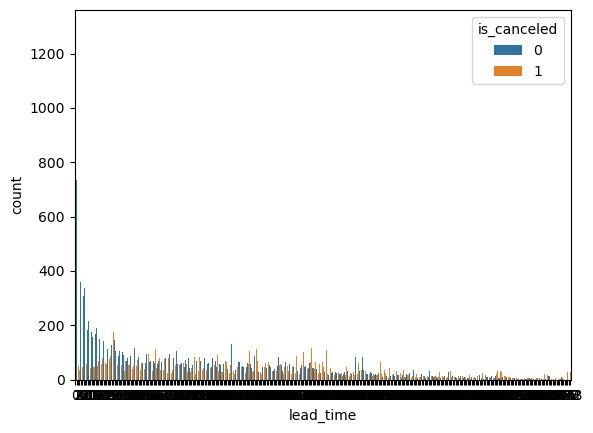

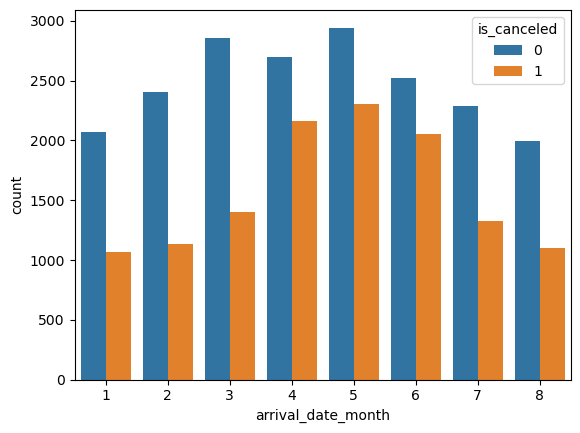

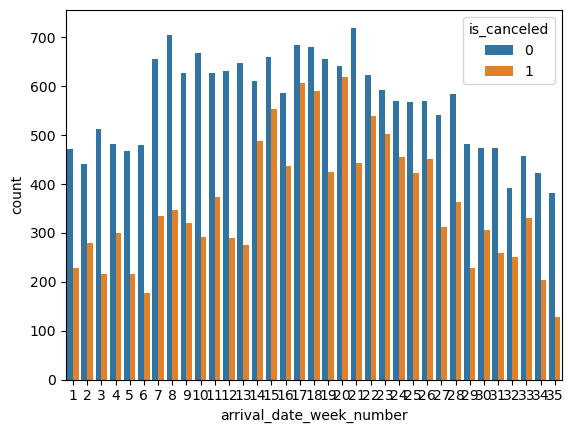

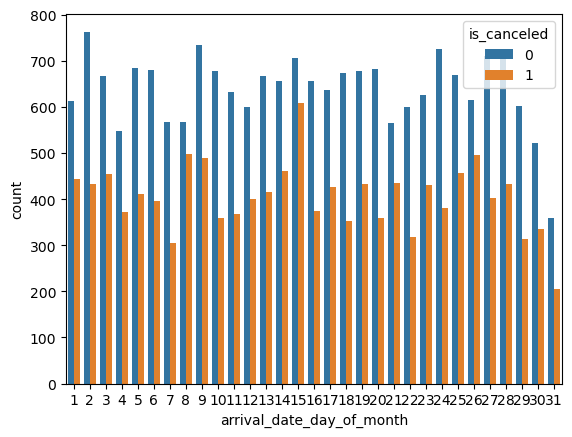

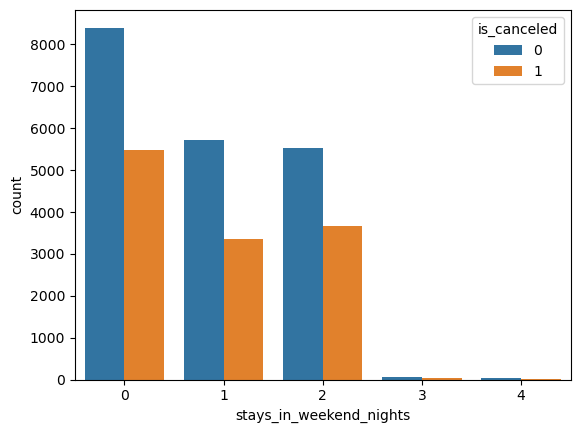

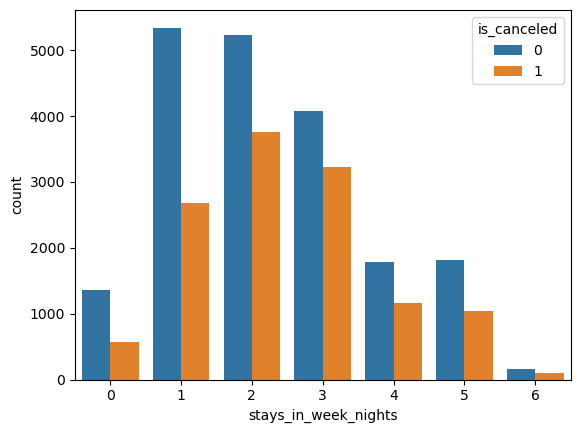

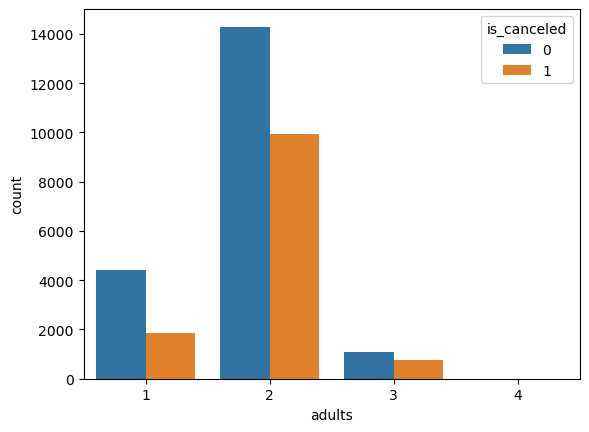

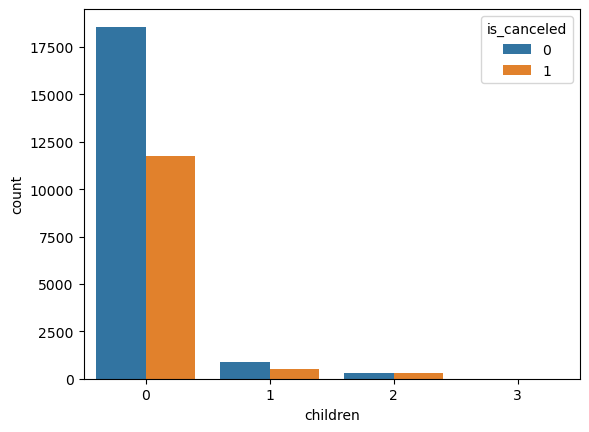

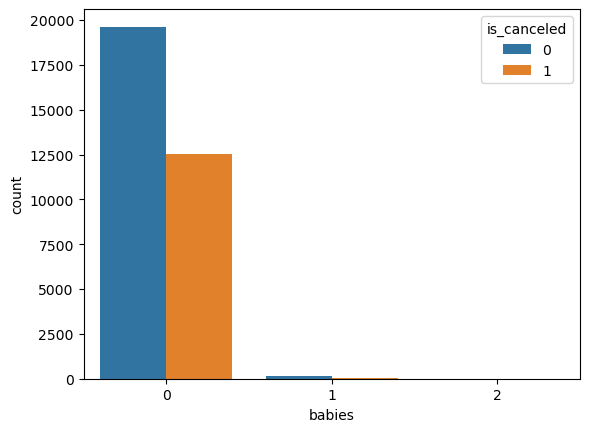

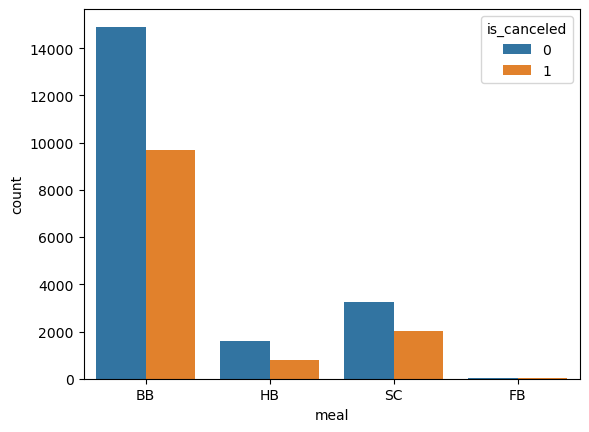

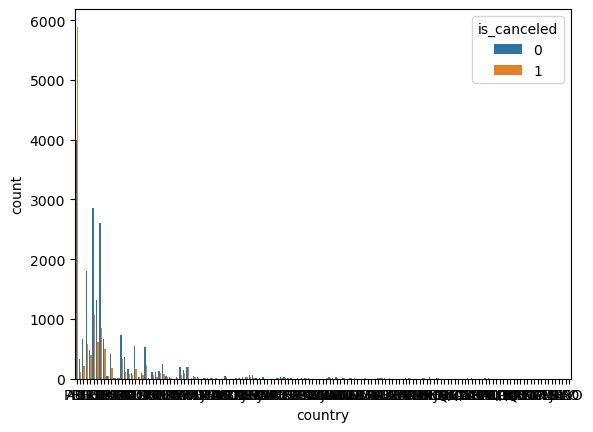

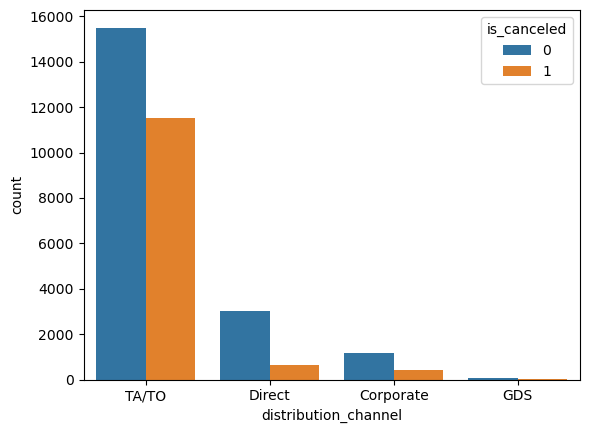

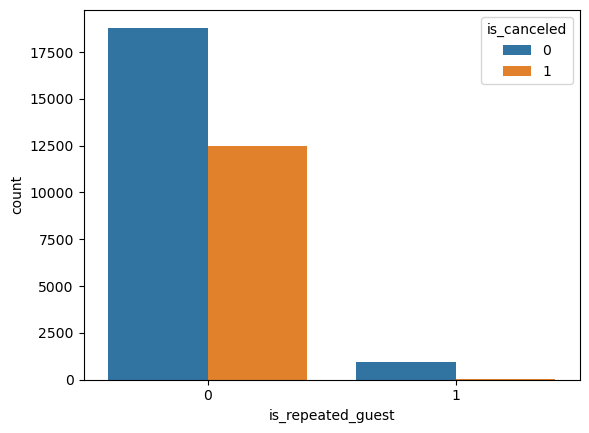

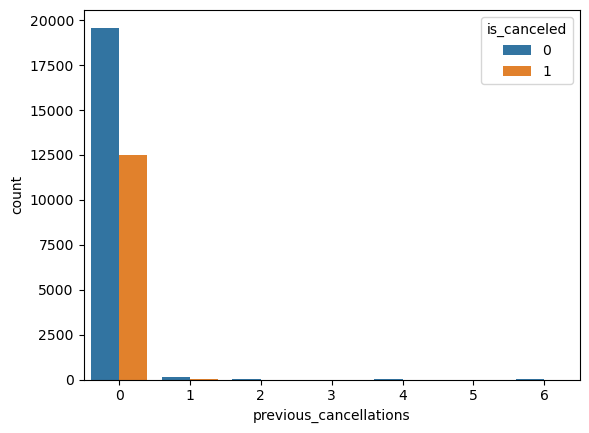

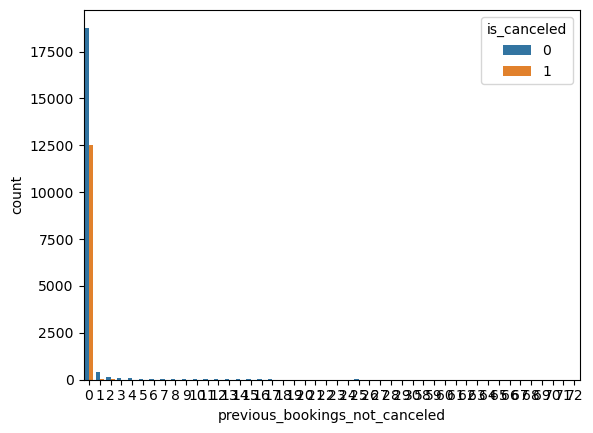

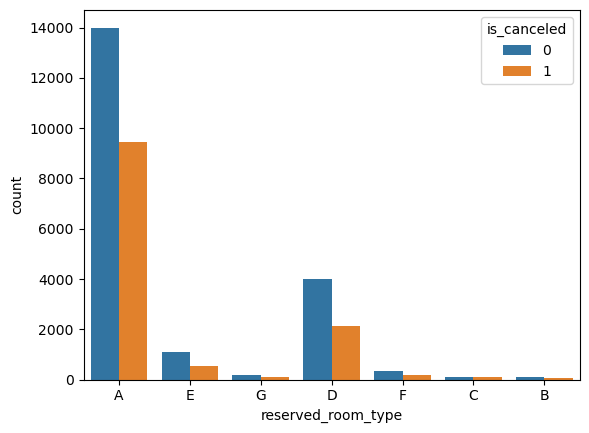

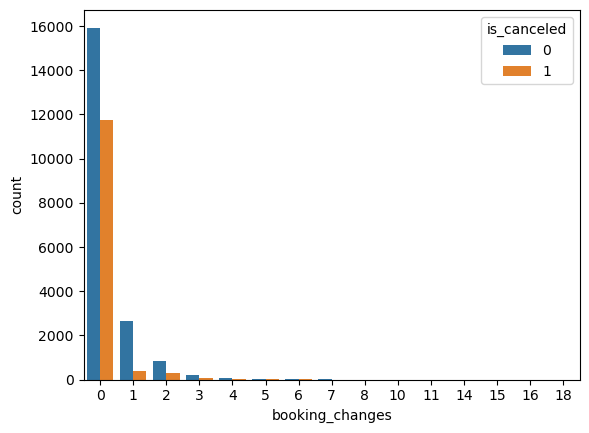

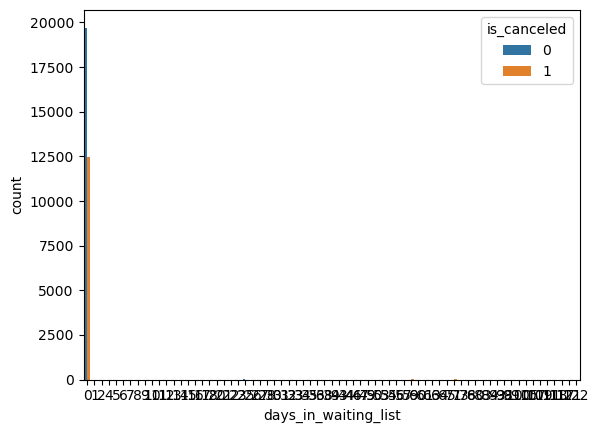

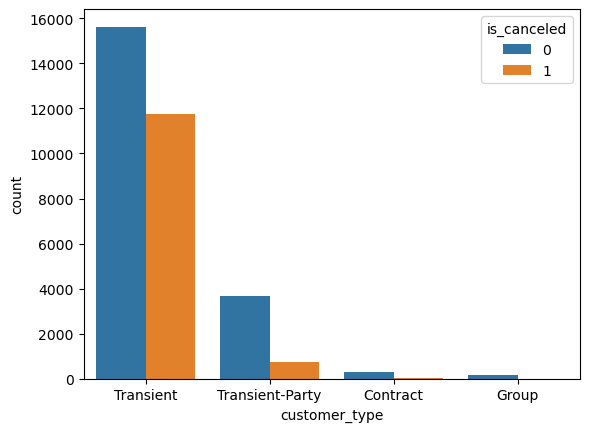

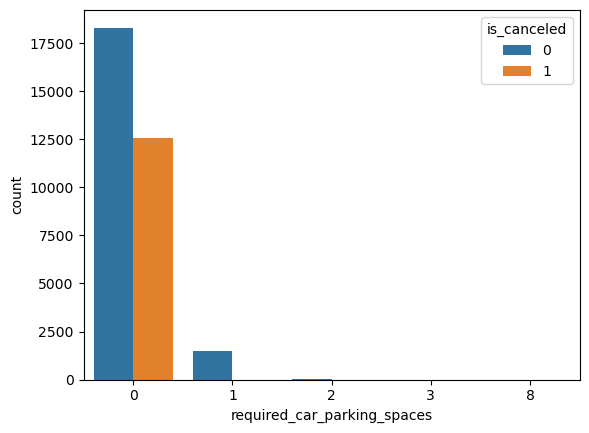

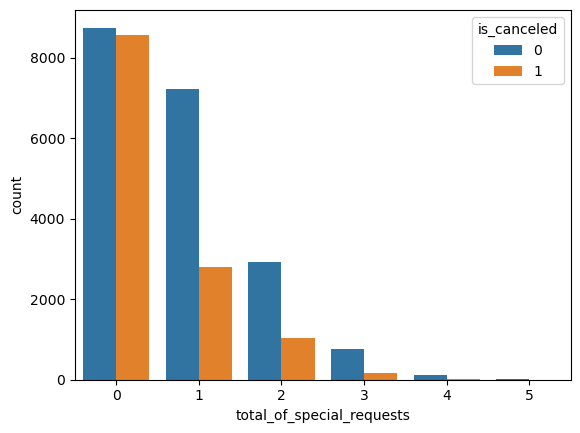

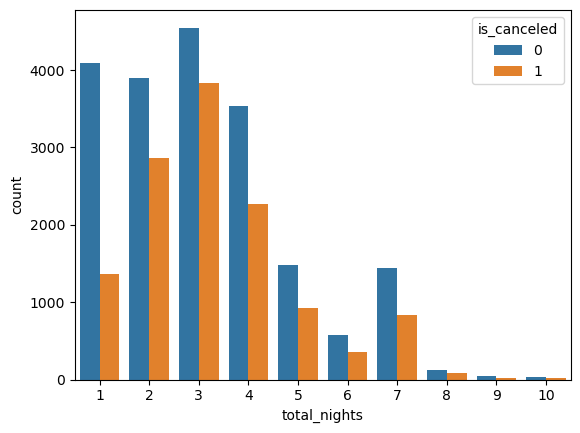

In [70]:
analize_columns = (
    df
    .drop([
    'id', 'is_canceled','arrival_date_year', 'profit', 'predicted', 'deposit', 'profit_b' ], axis = 1)
    .columns
    .to_list()
)

for col in analize_columns:
    sns.countplot(x=col, hue='is_canceled', data=df);
    plt.show()

По полученнным данных видно, что количество отмененных заказов коррелирует с количеством выполненных. И больше всего отмен, там же где и больше всего заказов. 

Но поподробнее стоит рассмотреть пару нюансов. Например данные в графе c информацией о количестве дней между датой бронирования и прибытия.

In [72]:
lead_time = df['lead_time'].value_counts().head(20)
df1 = df.query('lead_time in @lead_time')
sns.countplot(x='lead_time', hue='is_canceled', data=df1);

Чаще отменяют заказы те, кто делал заказ сильно заблаговременно, за 7 с половиной месяцев и более. 

Так же не очень понятны данные по тому сколько уже подтвержденных заказов у тек кто делает отмены.

In [73]:
df[df['is_canceled'] == 1]['previous_bookings_not_canceled'].value_counts().head(20)


previous_bookings_not_canceled
0     12505
1        24
2        11
10        3
7         3
14        2
13        2
3         2
11        1
5         1
26        1
16        1
4         1
Name: count, dtype: int64

Значительно чаще делают отменяют заказы те, для кого это первое бронирование.

In [74]:
df[df['is_canceled'] == 1]['days_in_waiting_list'].value_counts().head(15)

days_in_waiting_list
0     12454
71        6
59        5
44        4
46        4
28        4
16        4
26        4
17        4
5         3
34        3
7         3
60        3
27        2
11        2
Name: count, dtype: int64

Не очень понятная ситуация со странами.
Посмотрим отдельно топ15 стран с исполненными и отмененными заказами.

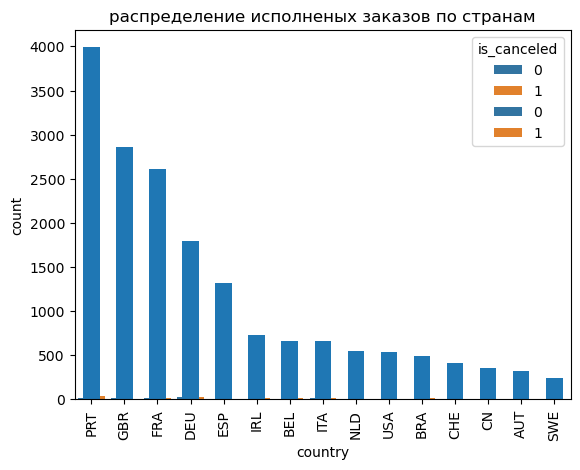

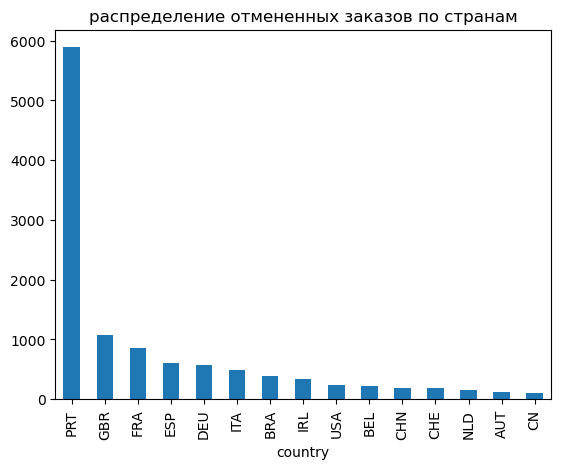

In [75]:
df[df['is_canceled'] == 0]['country'].value_counts().head(15).plot(
    kind='bar',
    x='country', 
    title='распределение исполненых заказов по странам')
plt.show();
df[df['is_canceled'] == 1]['country'].value_counts().head(15).plot(
    kind='bar',
    x='country', 
    title='распределение отмененных заказов по странам')
plt.show();

В топе 3 по заказам Португалия, Германия, и Франция. Португальцы самые непостоянные отменяют заказы гораздо чаще выполняют.

Так же состави график важности признака для отмены заказа.

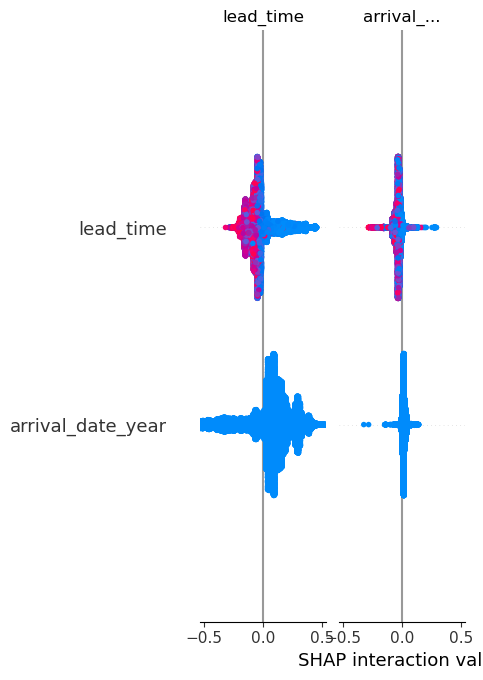

In [76]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(features_test)
shap.summary_plot(shap_values, features_test)


Из графика выше видно, что важным  факторм является неделея заезда, посмотрим подробнее распределение отмен по по неделям)

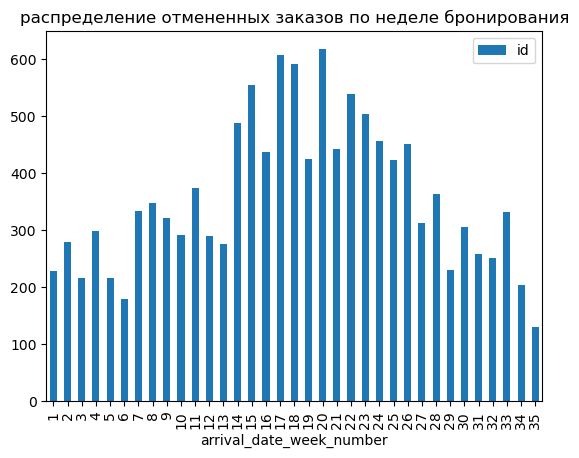

In [77]:
(
    df[df['is_canceled'] == 1].pivot_table(index='arrival_date_week_number',
                                           values='id',
                                           aggfunc='count')
    .plot(kind='bar', 
          title='распределение отмененных заказов по неделе бронирования')
)
plt.show();

Больше всего отмен приходиться с апреля по июнь, самые топовые недели это 21-я, 17-я и 18-я.

Итак, суммируя все вышесказанное, портрет неблагонадежного клиента:

    Житель(ница) Португалии, без особых заметок в заказе, сделавший заказ сильно заблаговременнно ( от 7 с половиной месяцев и более), которые путешествует "дикарем", делающий заказ впервые, без машины, в период с начала апреля по конец июня)

## Общий вывод

Для данной работы мы получили два массива данных. Их отредактировали, обработали и приобразовали:

- На данном этапе работы мы проверили данные на корректность форматов, исправили где необходимо:
    - Поменяли тип на целочисленный, в столбцах с указанием количества гостей, детей, младенцев. А так же в графе с информацией о количестве дней между бронированием и заездом.
    - Для удобства дальнейшей работы изменили название месяцев на номера.
- Изучили период времени за который представлены данные
    - в тренировочных данных содержится информация о 65 228 заказах сделанных в период июль 2015 - декабрь 2016.
    - в тестовых информация о заказах с январь по июль 2017-го.
- Данные проверены на наличие пропусков и дубликатов, явных и неявных. Оных не обнаружено.

- Заказы проверены на выбросы:

     - Исключены заказы длительность подтверждения которых больше 150 дней.
     - Исключены заказы в которых количество младенцев 9 и 10.
     - Так же исключены заказы в которых нет ни одного взрослого.

- Проведен анализ составлен график заказов по таким признакам как страна, длительность заезда, канал дистрибуции и какие дополнительно заказанным опциям.

    - Чаще прочих делают заказы с включенным завтраком. На втором месте, но в 3 раза реже встречается заказ без дополнительных опций. Самый непопулярный вариант это "включён завтрак, обед и ужин". Соотношение исполненных заказов пропорционально отмененным.

    - Чаще всего заказы поступают через TA/TO. Самый непопулярный канал дистрируции "GDS". Соотношение исполненных заказов пропорционально отмененным.

    - Самый популярное количество ночей для заказа 1-4, Заказы включающие 3 ночи, чаще других отменяются. Реже всего снимают номер на 8-10 ночей.   

    - Топ 3 по количеству заказов Португалия, Германия и Франция. Португальцы так же и самые непостоянные, отменяют заказы чаще, чем приезжают.

____________________________

Затем написали функцию которая рассчитала прибыль от всех заказов, положительную от исполненных и отрицательную от отененных.
- Далее с использованием этих данных мы сделали сводную таблицу в которой был указана суммарная доход и убыток по месяцам, а так же дополнили столбцами с расчитанными значениями:
    - общее количество всех заказов
    - доля отмененных заказов и всех
    - прибыль с вычетом убытков
- Полученнные данные были проанализированы

 **АНАЛИТИКА ПО 2015-му ГОДУ:**

    - За 2015-й год доход от исполненных заказов составил 28 868 480 руб, с вычетом убытков от отмененных заказов (а это 11 436 410 рублей) 17 432 070 .

    - Заказов за этот перод время было 18314, 39% из них, то есть 7188 были отменены

    - Самый прибыльный месяц с июля по декабрь - октябрь 4 368 690 руб

    - Самая маленькая прибыль обозначенного периода за декабрь 1 727 100 руб.
    
  **АНАЛИТИКА ПО 2016-му ГОДУ:**

    - За 2016-й год доход от исполненных заказов составил 66 905 590 руб, c с вычетом убытков от отмененных заказов (а это 24 214 380 рублей) 42 691 210.0 .

    - Заказов за этот перод время было 46 901, 36% из них, то есть 16 852 были отменены  

    - Самый прибыльным периодом ожидаемо оказалось лето, самый топовый месяц - июль прибыль 1 081 250 руб

    - Самая маленькая прибыль обозначенного периода за январь 2 465 350 руб.
    
  **АНАЛИТИКА ПО 2016-му ГОДУ:**

    - За первое полугодие 2017-го года доход от исполненных заказов составил 50 494 480 руб, с вычетом убытков от отмененных заказов (а это 17 995 870 рублей) 32 498 610.

    - Заказов за этот перод времени было 32335, 38,8% из них, то есть 12 557 были отменены

    - Самый прибыльным  месяцем оказался март, прибыль 5 049 730 руб.

    - Самая маленькая прибыль обозначенного периода  - январь  2 167 850 руб.

Далее была разработана модель для предсказания отмены клиентом заказа.

________

На данном этапе работы были изучены модели:
- линейная регрессия
- дерево решений
- лес случайных моделей

Для каждой были подобораны параметры, при которых модель показывала лучший результат.

Далее был выявлен дисбаланс классов. И была разработана модель на выборке увеличенной по мироториному признаку
Для каждой подобраны лучшие параметры и расчитан индивидуальный recall.
дерево решений обученнная на увеченной подборке.

**Показатели recall на различных выборках**


| Модель                     | Несблансированная выборка| Увеличенный минор |
|----------------------------|--------------------------|-------------------|
| Логистическая регрессия    |          0.567          |       0.759      | 
| Дерево решений             |          0.532           |      **0.816**      | 
| Лес случайных деревьев     |          0.503           |       0.804      |


Предсказанные ею значения добавлены в таблицу с тестовыми данными. Но основании их расчитан обязательный депозит, с учетом этого рассчитана прибыль отеля после внедрения новшеств.

Разница в прибыли с внедрением системы составляет больше 7.8 млн рублей.

Это во много раз больше затраченнных на производство 400 000 рублей. 


Так же в ходе работы были проанализированы отменные заказы, По полученнным данных видно:

- что количество отмененных заказов коррелирует с количеством выполненных. И больше всего отмен, там же где и больше всего заказов. 
- Чаще отменяют заказы те, кто делал заказ сильно заблаговременно, за 7 с половиной месяцев и более. 
- Значительно чаще делают отменяют заказы те, для кого это первое бронирование.
- В топе 3 по заказам Португалия, Германия, и Франция. Португальцы самые непостоянные отменяют заказы гораздо чаще выполняют.
- Больше всего отмен приходиться с апреля по июнь, самые топовые недели это 21-я, 17-я и 18-я.

Итак, суммируя все вышесказанное, портрет неблагонадежного клиента:

    Житель(ница) Португалии, без особых заметок в заказе, сделавший заказ сильно заблаговременнно ( от 7 с половиной месяцев и более), которые путешествует "дикарем", делающий заказ впервые, без машины, в период с начала апреля по конец июня)
